In [1]:
# Import libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
import scipy
from torchmetrics.image.fid import FrechetInceptionDistance
import cv2
import skimage

In [2]:
'''
Define parameters
'''
n_steps = 200
batch_size = 128
num_images = 25
n_real = 10  ## how many real images we want to sent in the Inception Model to get the FID score. i.e. 128 * n_real images will be sent. 
n_samples = 256  ## how many images we eant to generate
n_feature = 192  ## the parameter of FID calcultion. Needs to be in the range[64, 192, 768, 2048]. The bigger it is, the better the preformance is. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./Results/Mine/MNIST/Results_epoch_30/ddpm_mnist.pt"
datasets_path = "./datasets"

In [3]:
'''
Rescale the images
'''
def scale_image(images, new_shape):
    new_images = []
    for image in images:
        new_image = skimage.transform.resize(image, new_shape, 0)
        new_image = cv2.normalize(new_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        new_images.append(new_image)
    return np.asarray(new_images, dtype=np.uint8)

In [4]:
'''
FID calculation
'''
def get_fid(images1: torch.Tensor, images2: torch.Tensor, n_feature=64) -> torch.Tensor:
    new_size = (3, 299, 299)
    fid = FrechetInceptionDistance(feature=n_feature)
    real = images1.clone()
    fake = images2.clone()
    
    # convert into numpy to resize
    if type(real) is torch.Tensor:
        real = real.detach().numpy()
        
    if type(fake) is torch.Tensor:
        fake = fake.detach().numpy()
        
    # resize to (3, 299, 299)
    images1 = scale_image(real, new_size)
    images2 = scale_image(fake, new_size)
    
    # convert it back to tensor
    images1 = torch.tensor(images1)
    images2 = torch.tensor(images2)
    
    # update the fid with new tensor
    print("\nUpdating the fid calculator....\n")
    fid.update(images1, real=True)
    fid.update(images2, real=False)
    
    # get the fid score
    score = fid.compute()
    print("\nThe current FID score = {}. \n".format(score))
    # print("The FID score between the train dataset and the generated = {}. ".format(score))
    fid.reset()
    
    return score

In [5]:
'''
To generate new images, we start with random noise and let t go from 
T back to 0. At each step, we estimate the noise as eta_theta and apply
the denoising function. Finally, extr noise is added as in Langevin 
dynamics. 
'''
def generate_new_images(ddpm, n_samples=256, device=None, c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
    return x

In [6]:
'''
Complete generation function that can store the results from each step.
'''
def generate_new_images_complete(ddpm, n_samples=256, device=None, c=1, h=28, w=28):
    images_for_show = []
    images_for_cal = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            
            # convert the generated to 
            normalized = x.clone()
            for i in range(len(normalized)):
                normalized[i] -= torch.min(normalized[i])
                normalized[i] *= 255 / torch.max(normalized[i])
            images_for_cal.append(normalized)
            
            # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
            image = einops.rearrange(normalized[:num_images], "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(num_images ** 0.5))
            image = image.cpu().numpy().astype(np.uint8)
            
            # Rendering frame
            images_for_show.append(image)
                
    return x, images_for_show, images_for_cal

In [7]:
'''
Create DDPM model to save alpha and beta values and apply 
the forward process. 
'''
# class DDPM
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added. (use U-Net)
        return self.network(x, t)

In [8]:
'''
Create U-Net model to predict the noise in the images given 
the image and the current time step. First of all, we define 
a block that will keep spatial dimensionality unchanged. This
block will be used at every level of U-Net. 
'''
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [9]:
'''
After building the block, we use sinusoidal embedding and one layer
of MLPs to keep our image-to-image model conditional on the current 
time step. 
'''
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [10]:
'''
Create a small utility function to generate a one-layer MLP which
will be used to map positional embeddings.
'''
def _make_te(self, dim_in, dim_out):
  return nn.Sequential(
    nn.Linear(dim_in, dim_out),
    nn.SiLU(),
    nn.Linear(dim_out, dim_out)
  )

In [11]:
'''
For the details in U-Net, we have 3 down-sample parts, a bottleneck
in the middle of the network, and 3 up-sample steps with the usual
U-Net residual connections (concatenations). 
'''
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [12]:
'''
Load the trained model. 
'''
model = MyDDPM(network=MyUNet(n_steps=n_steps),
               n_steps=n_steps,
               device=device)
model.load_state_dict(torch.load(model_path, 
                                 map_location=device))
model.eval()
print("\nModel is loaded from " + model_path + ". \n")


Model is loaded from ./Results/Mine/MNIST/Results_epoch_30/ddpm_mnist.pt. 



In [13]:
'''
Prepare the real images
'''
print("\nGenerating the real images.... \n")
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = MNIST
dataset = ds_fn(datasets_path, 
                download=True,
                train = True,
                transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)
batches = []
cnt = 0
for batch in loader:
    if (cnt == n_real):
        break
    batches.append(batch[0])
    cnt += 1
real = batches[0]
for i in range(1, len(batches)):
    real = torch.cat((real, batches[i]))
print("\nThe real images are prepared. \n")
print("\nThe shape of real images = {}. \n".format(real.shape))



Generating the real images.... 


The real images are prepared. 


The shape of real images = torch.Size([1280, 1, 28, 28]). 



(140, 140, 1)


(-0.5, 139.5, 139.5, -0.5)

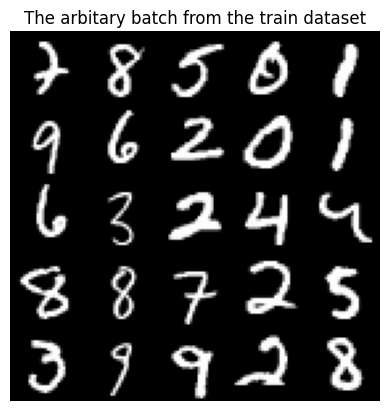

In [14]:
'''
Show arbitary batch of real images. 
'''
real_images = real[:num_images]
real_images = einops.rearrange(real_images, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(num_images ** 0.5))
real_images = real_images.detach().numpy()
print(real_images.shape)

plt.imshow(real_images, cmap='gray')
title = f"The arbitary batch from the train dataset"
plt.title(title)
plt.axis('off')


In [15]:
'''
Generate the fake images. 
'''
print("\nGenerating the fake images......\n")
# fake = generate_new_images(ddpm=model,
#                            n_samples=256,
#                            device=device)
fake, fakes_for_show, fakes_for_cal = generate_new_images_complete(ddpm=model, 
                                           n_samples=n_samples,
                                           device=device)
print("\nThe shape of fake images = {}. \n".format(fake.shape))
print("\nThere are {} sets of images in fakes. \n".format(len(fakes_for_show)))
print(fakes_for_cal[0].shape)



Generating the fake images......


The shape of fake images = torch.Size([256, 1, 28, 28]). 


There are 200 sets of images in fakes. 

torch.Size([256, 1, 28, 28])


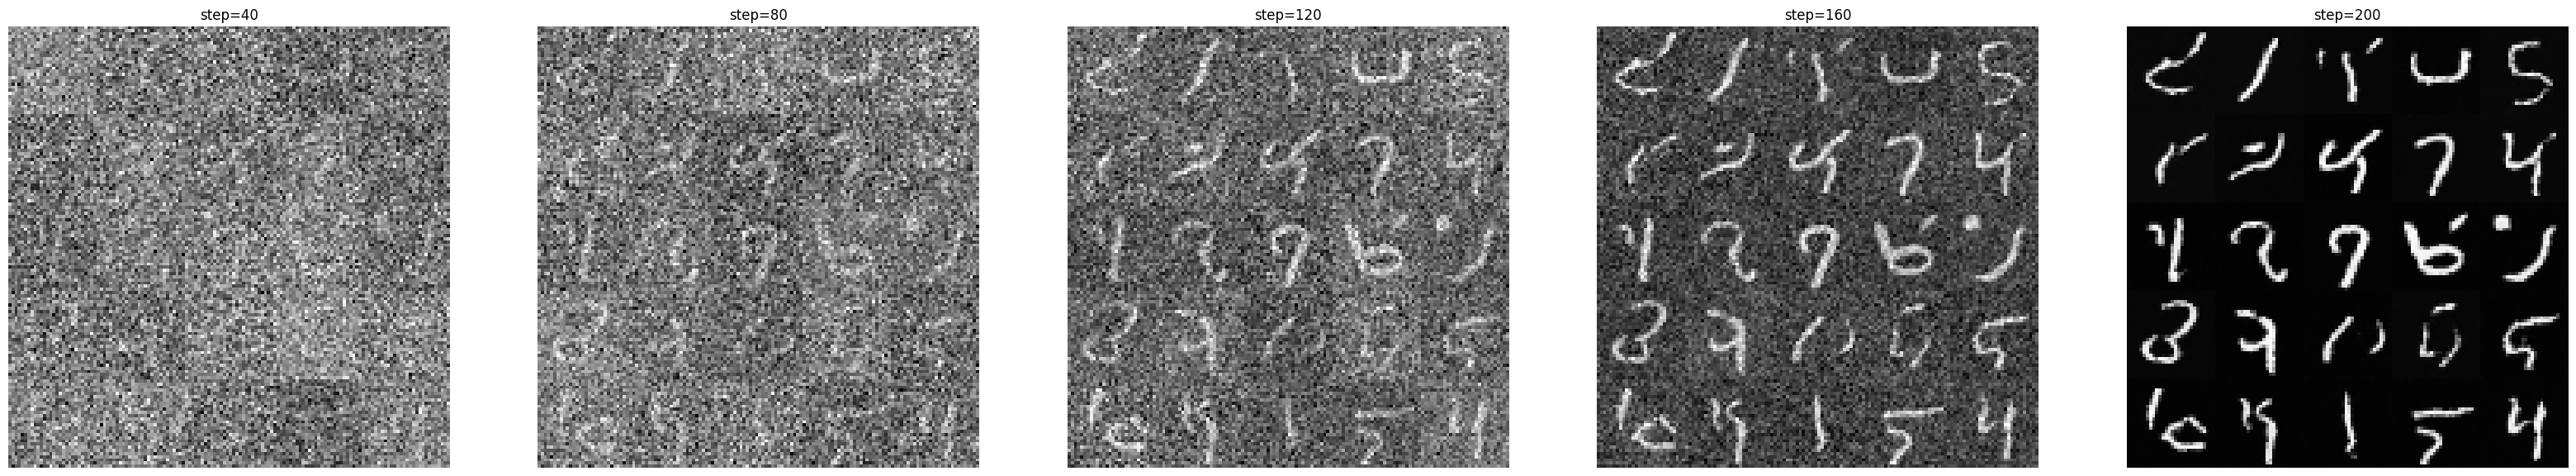

In [16]:
'''
Visualize 
'''
image_step = 40
cols = len(fakes_for_show) // image_step
fig = plt.figure(figsize=(8*cols, 12))
cnt = 1
for i in range(len(fakes_for_show)):
    if (i+1) % image_step == 0:
        fig.add_subplot(1, cols, cnt)
        plt.imshow(fakes_for_show[i], cmap='gray')
        plt.axis('off')
        title = f"step={i+1}"
        plt.title(title)
        cnt += 1

In [17]:
'''
Calculate the FID score for every 40 step
'''
image_step = 20
FID_record = []
for i in range(len(fakes_for_show)):
    if (i+1) % image_step == 0:
        FID_record.append([i+1, get_fid(images1=real,
                                        images2=fakes_for_cal[i],
                                        n_feature=n_feature)])
FID_record = np.asarray(FID_record, dtype='float32')



Updating the fid calculator....


The current FID score = 335.115234375. 


Updating the fid calculator....


The current FID score = 328.99346923828125. 


Updating the fid calculator....


The current FID score = 323.7366943359375. 


Updating the fid calculator....


The current FID score = 315.3312683105469. 


Updating the fid calculator....


The current FID score = 301.2897033691406. 


Updating the fid calculator....


The current FID score = 282.97564697265625. 


Updating the fid calculator....


The current FID score = 259.1527404785156. 


Updating the fid calculator....


The current FID score = 226.5858917236328. 


Updating the fid calculator....


The current FID score = 170.73802185058594. 


Updating the fid calculator....


The current FID score = 2.016544818878174. 



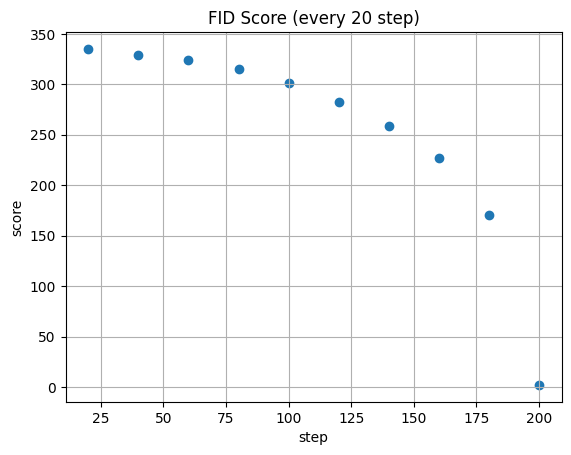

In [18]:
fig_fid_steps = plt.figure()
plt.scatter(FID_record[:, 0], FID_record[:, 1])
plt.title("FID Score (every {} step)".format(image_step))
plt.xlabel("step")
plt.ylabel("score")
plt.grid(visible=True)
plt.savefig("./reverse_FID_MNIST.png")
# plt.close(fig_fid_steps)

In [19]:
'''
Calculate the FID score
'''
print("\nCalculating the FID score......\n")
# scores = []
# for i in [0, 99, 199, 299]:
#     fake_step = fakes[i]
#     score = get_fid(images1=real,
#                     images2=fake_step,
#                     n_feature=n_feature)
#     scores.append(score)
score = get_fid(images1=real,
                images2=fake,
                n_feature=n_feature)


Calculating the FID score......


Updating the fid calculator....


The current FID score = 2.016544818878174. 



(-0.5, 139.5, 139.5, -0.5)

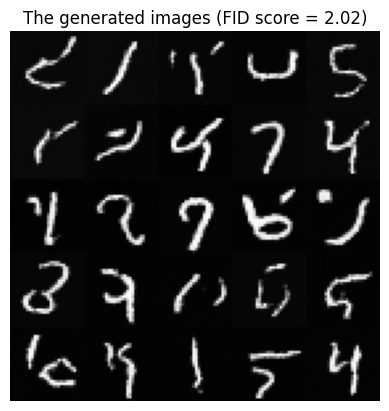

In [20]:
plt.imshow(fakes_for_show[len(fakes_for_show)-1], cmap='gray')
title = f"The generated images (FID score = {score:.2f})"
plt.title(title)
plt.axis('off')